In [1]:
# Data analysis libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import calendar

# Matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# Show table names, columns, and data types
for table in Base.classes:
    print(f"Table name: {table.__table__.name}")
    for c in table.__table__.columns:
        print(f"   {c.name} {c.type}", end='')
        if c.primary_key:
            print("  PRIMARY KEY")
        else:
            print()

Table name: measurement
   id INTEGER  PRIMARY KEY
   station TEXT
   date TEXT
   prcp FLOAT
   tobs FLOAT
Table name: station
   id INTEGER  PRIMARY KEY
   station TEXT
   name TEXT
   latitude FLOAT
   longitude FLOAT
   elevation FLOAT


In [5]:
# Save references to each table
Meas = Base.classes.measurement
Sta = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [8]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [9]:
# Show Period of Record for each station
sel = [Meas.station,
       func.min(Meas.date), 
       func.max(Meas.date),
       Sta.name]
sta_daterange = session.query(*sel).\
    filter(Meas.station == Sta.station).\
    group_by(Meas.station).\
    order_by(Sta.name).all()
sta_daterange

[('USC00511918', '2010-01-01', '2015-10-30', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', '2010-01-01', '2017-07-31', 'KANEOHE 838.1, HI US'),
 ('USC00514830', '2010-03-01', '2017-08-23', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', '2010-01-01', '2017-08-23', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', '2010-05-03', '2017-07-31', 'PEARL CITY, HI US'),
 ('USC00518838', '2010-01-01', '2015-11-20', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', '2010-01-01', '2017-08-18', 'WAIHEE 837.5, HI US'),
 ('USC00519397', '2010-01-01', '2017-08-23', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', '2010-01-01', '2017-08-23', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

### Plot 12 months of precipitation data

In [10]:
# Retrieve 12 months of precipitation data spanning 2016-08-01 through 2017-07-31
sel = [Meas.station,
       Meas.date,
       Meas.prcp]

enddate = dt.date.fromisoformat('2017-07-31')
startdate = enddate - dt.timedelta(days=364)

sta_prcp = session.query(*sel).\
    filter(Meas.date >= startdate).\
    filter(Meas.date <= enddate).all()

for row in sta_prcp[0:10]:
    print(row)
print(f"\nRecord count: {len(sta_prcp)}")

('USC00519397', '2016-08-01', 0.08)
('USC00519397', '2016-08-02', 0.05)
('USC00519397', '2016-08-03', 0.0)
('USC00519397', '2016-08-04', 0.04)
('USC00519397', '2016-08-05', 0.01)
('USC00519397', '2016-08-06', 0.0)
('USC00519397', '2016-08-07', 0.39)
('USC00519397', '2016-08-08', 0.02)
('USC00519397', '2016-08-09', 0.0)
('USC00519397', '2016-08-10', 0.0)

Record count: 2281


In [11]:
# Save the query results as a Pandas DataFrame
cols = ['Sta_ID', 'Date', 'Prec']
df_sta_prcp = pd.DataFrame(sta_prcp, columns=cols)
# df_sta_prcp['Coop_ID'] = df_sta_prcp['Sta_ID'].str[-6:]
# df_sta_prcp.drop(columns=['Sta_ID'], inplace=True)
display(df_sta_prcp.head(5))

# Get list of unique stations
sta_prcp_list = sorted(list(df_sta_prcp['Sta_ID'].unique()))

df_prcp = pd.pivot_table(df_sta_prcp, values='Prec', index='Date', columns='Sta_ID', aggfunc='first')

df_prcp.index = pd.to_datetime(df_prcp.index)
display(df_prcp.head(5))

print(f"\nThe data type of the index (date) column is {df_prcp.index.dtype}\n")

print("The following Dataframe shows the observation count and sum of precipitation for each station\n")
pd.concat([df_prcp.count(), df_prcp.sum()], axis=1, keys=['Count', 'Mean Prec'])



,Sta_ID,Date,Prec
0,USC00519397,2016-08-01,0.08
1,USC00519397,2016-08-02,0.05
2,USC00519397,2016-08-03,0.00
3,USC00519397,2016-08-04,0.04
4,USC00519397,2016-08-05,0.01


Sta_ID,USC00513117,USC00514830,USC00516128,USC00517948,USC00519281,USC00519397,USC00519523
Date,,,,,,,
2016-08-01,2.35,NaN,2.21,NaN,3.53,0.08,0.54
2016-08-02,0.20,0.55,1.14,0.00,0.83,0.05,0.07
2016-08-03,0.02,0.00,NaN,0.02,0.01,0.00,0.00
2016-08-04,0.62,NaN,NaN,0.13,0.77,0.04,0.25
2016-08-05,0.03,NaN,NaN,0.03,0.27,0.01,0.00



The data type of the index (date) column is datetime64[ns]

The following Dataframe shows the observation count and sum of precipitation for each station



,Count,Mean Prec
Sta_ID,,
USC00513117,365,54.39
USC00514830,260,34.14
USC00516128,331,157.91
USC00517948,67,4.77
USC00519281,365,79.49
USC00519397,360,17.18
USC00519523,319,39.80


## Use Pandas Plotting with Matplotlib to plot the data

In [12]:
# Discard Coop_ID 517948 since it has limited data
df_prcp2 = df_prcp.drop(columns='USC00517948')

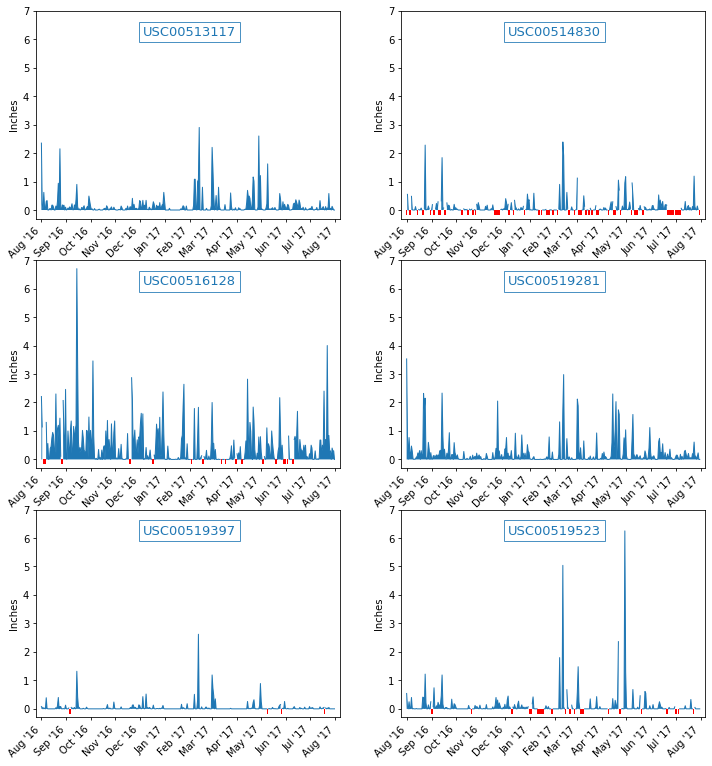

In [13]:

dates = df_prcp2.index
xmin = startdate - dt.timedelta(days=7)
xmax = enddate + dt.timedelta(days=7)


axs = plt.figure(figsize=(12,13)).subplots(3,2)
plt.setp(axs, ylim=([-0.3,7]), xlim=([xmin,xmax]), ylabel='Inches')
bbox_props = dict(boxstyle="square", fc="w", ec='tab:blue', alpha=0.8)
axs = axs.flat

for ax,station in zip(axs, df_prcp2.columns):
    prec = df_prcp2[station].values
    NaNs = [-0.17 if np.isnan(x) else np.nan for x in prec]
    ax.plot(dates, prec, linewidth=1)                                   # width=pd.Timedelta(days=1)
    ax.fill_between(dates, df_prcp2[station])
    ax.bar(dates, NaNs, color='red', width=pd.Timedelta(days=1))
    ax.text(dt.datetime(2017,2,1), 6.25, station, color='tab:blue', ha="center", va="center", size=13, bbox=bbox_props)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')    
    ax.tick_params(axis='both', length=3)


# plt.savefig('prec_plots.png', dpi=300)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp2.describe()

Sta_ID,USC00513117,USC00514830,USC00516128,USC00519281,USC00519397,USC00519523
count,365.000000,260.000000,331.000000,365.000000,360.000000,319.000000
mean,0.149014,0.131308,0.477069,0.217781,0.047722,0.124765
std,0.354761,0.320596,0.732042,0.462878,0.190305,0.506417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
50%,0.030000,0.020000,0.220000,0.060000,0.000000,0.000000
75%,0.130000,0.120000,0.700000,0.200000,0.020000,0.070000
max,2.900000,2.390000,6.700000,3.530000,2.620000,6.250000


In [15]:
# Design a query to show how many stations are available in this dataset?
# len(session.query(Meas.station).distinct().all())
session.query(Meas.station).distinct().count()


9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [func.count(Meas.tobs),
       func.count(Meas.prcp),
       Meas.station,
       Sta.name]

sta_obs_list = session.query(*sel).\
    filter(Meas.station == Sta.station).\
    group_by(Meas.station).\
    order_by(func.count(Meas.tobs).desc()).all()

df_obs_count = pd.DataFrame(sta_obs_list, columns=['Temp Count','Prec count','Sta_ID','Station Name'])
df_obs_count

,Temp Count,Prec count,Sta_ID,Station Name
0,2772,2772,USC00519281,"WAIHEE 837.5, HI US"
1,2724,2685,USC00519397,"WAIKIKI 717.2, HI US"
2,2709,2696,USC00513117,"KANEOHE 838.1, HI US"
3,2669,2572,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
4,2612,2484,USC00516128,"MANOA LYON ARBO 785.2, HI US"
5,2202,1937,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
6,1979,1932,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
7,1372,683,USC00517948,"PEARL CITY, HI US"
8,511,342,USC00518838,"UPPER WAHIAWA 874.3, HI US"


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Meas.station,
       func.max(Meas.tobs),
       func.min(Meas.tobs),
       func.avg(Meas.tobs)]

temp_stats = session.query(*sel).\
    filter(Meas.station == 'USC00519281').\
    group_by(Meas.station).all()

print(f"Temperature stats for station {temp_stats[0][0]}:")
print(f"   Max  {temp_stats[0][1]}")
print(f"   Min  {temp_stats[0][2]}")
print(f"   Mean {temp_stats[0][3]:.1f}")


Temperature stats for station USC00519281:
   Max  85.0
   Min  54.0
   Mean 71.7


365


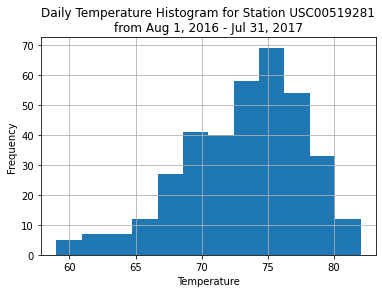

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sta_temp = session.query(Meas.date, Meas.tobs).\
    filter(Meas.station == 'USC00519281').\
    filter(Meas.date >= startdate).\
    filter(Meas.date <= enddate).\
    order_by(Meas.date).all()

df_temp = pd.DataFrame(sta_temp, columns=sta_temp[0].keys())

print(len(df_temp))

df_temp.hist(column='tobs', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Daily Temperature Histogram for Station USC00519281\nfrom Aug 1, 2016 - Jul 31, 2017')
plt.show()

## My Own Bonus Challenge

In [19]:
sel = [Meas.station, 
       func.min(Meas.date), 
       func.max(Meas.date),
       func.count(Meas.prcp),
       func.count(Meas.tobs)]
sta_summary = session.query(*sel).\
    group_by(Meas.station).\
    order_by(Meas.station).all()
cols = ['Sta_ID','Start Date','End Date', 'Prec Count', 'Temp Count']
df_obs_dates = pd.DataFrame(sta_summary, columns=cols)
df_obs_dates['Start Date'] = pd.to_datetime(df_obs_dates['Start Date'])
df_obs_dates['End Date'] = pd.to_datetime(df_obs_dates['End Date'])
df_obs_dates['Date Diff (days)'] = (df_obs_dates['End Date'] - df_obs_dates['Start Date']).dt.days + 1
df_obs_dates.set_index('Sta_ID', inplace=True)

df_prec_report = df_obs_dates[['Start Date','End Date', 'Prec Count', 'Date Diff (days)']]
df_prec_report['Percent Complete'] = round(df_prec_report['Prec Count'] / df_prec_report['Date Diff (days)'] * 100, 2)
df_prec_report.drop(columns=['Date Diff (days)'], inplace=True)
display(df_prec_report)

df_temp_report = df_obs_dates[['Start Date','End Date', 'Temp Count', 'Date Diff (days)']]
df_temp_report['Percent Complete'] = round(df_temp_report['Temp Count'] / df_temp_report['Date Diff (days)'] * 100, 2)
df_temp_report.drop(columns=['Date Diff (days)'], inplace=True)
display(df_temp_report)



,Start Date,End Date,Prec Count,Percent Complete
Sta_ID,,,,
USC00511918,2010-01-01,2015-10-30,1932,90.75
USC00513117,2010-01-01,2017-07-31,2696,97.36
USC00514830,2010-03-01,2017-08-23,1937,70.87
USC00516128,2010-01-01,2017-08-23,2484,88.97
USC00517948,2010-05-03,2017-07-31,683,25.80
USC00518838,2010-01-01,2015-11-20,342,15.91
USC00519281,2010-01-01,2017-08-18,2772,99.46
USC00519397,2010-01-01,2017-08-23,2685,96.17
USC00519523,2010-01-01,2017-08-23,2572,92.12


,Start Date,End Date,Temp Count,Percent Complete
Sta_ID,,,,
USC00511918,2010-01-01,2015-10-30,1979,92.95
USC00513117,2010-01-01,2017-07-31,2709,97.83
USC00514830,2010-03-01,2017-08-23,2202,80.57
USC00516128,2010-01-01,2017-08-23,2612,93.55
USC00517948,2010-05-03,2017-07-31,1372,51.83
USC00518838,2010-01-01,2015-11-20,511,23.77
USC00519281,2010-01-01,2017-08-18,2772,99.46
USC00519397,2010-01-01,2017-08-23,2724,97.56
USC00519523,2010-01-01,2017-08-23,2669,95.59


In [20]:
sel = [Meas.station, Meas.date, Meas.prcp, Meas.tobs]
df_meas = pd.DataFrame(session.query(*sel), columns=['Sta_ID','Date','Prec','Temp'])
df_meas['Date'] = pd.to_datetime(df_meas['Date'])

# Check all dates included in db date range
numdates_df = df_meas['Date'].nunique()
daterange_df = df_meas['Date'].max() - df_meas['Date'].min() + dt.timedelta(days=1)
print(numdates_df, daterange_df.days)

# https://stackoverflow.com/questions/46319852/pandas-monthly-date-range-with-number-of-days
start_d = dt.date(2010, 1, 1)
end_d = dt.date(2017, 7, 30)
s = pd.Series(index=pd.date_range(start_d, end_d), dtype='object')
s_daysinmonth = s.resample('MS').size().to_period('m').rename_axis('Year_Mo')

df_meas['Year_Mo'] = pd.PeriodIndex(df_meas['Date'],  freq="M")
df_meas.drop(df_meas[df_meas['Year_Mo'] == pd.Period(value='2017-08')].index, inplace = True)


2792 2792


In [88]:
df_prec_count = pd.pivot_table(df_meas, values='Prec', index='Year_Mo', columns='Sta_ID', aggfunc='count')
df_prec_pcnt = df_prec_count.divide(s_daysinmonth, axis=0)

cm = sns.light_palette("darkred", as_cmap=True).reversed()
display(df_prec_pcnt.style.background_gradient(cmap=cm, axis=None))

df_prec_sum = pd.pivot_table(df_meas, values='Prec', index='Year_Mo', columns='Sta_ID', aggfunc='sum')
df_prec_sum = df_prec_sum.divide(df_prec_pcnt, axis=0)

sta_keep = ['USC00513117','USC00516128','USC00519281','USC00519397','USC00519523']
df_prec_sum = df_prec_sum[sta_keep]
display(df_prec_sum.style.background_gradient(cmap='YlGnBu'))

Sta_ID,USC00511918,USC00513117,USC00514830,USC00516128,USC00517948,USC00518838,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,,,,,
2010-01,0.935484,1.000000,nan,1.000000,nan,0.548387,1.000000,0.838710,1.000000
2010-02,0.892857,0.892857,nan,0.892857,nan,0.571429,1.000000,0.785714,1.000000
2010-03,0.967742,1.000000,0.838710,1.000000,nan,0.387097,1.000000,0.774194,1.000000
2010-04,1.000000,1.000000,0.933333,0.933333,nan,0.500000,1.000000,0.866667,1.000000
2010-05,0.935484,1.000000,0.838710,0.774194,0.516129,0.645161,1.000000,0.903226,0.935484
2010-06,0.966667,1.000000,0.933333,0.600000,0.666667,0.600000,1.000000,1.000000,0.966667
2010-07,0.838710,1.000000,0.838710,1.000000,0.419355,0.354839,1.000000,0.838710,1.000000
2010-08,1.000000,1.000000,1.000000,1.000000,0.677419,0.451613,1.000000,1.000000,1.000000
2010-09,0.933333,0.933333,1.000000,1.000000,0.633333,0.566667,1.000000,0.966667,1.000000


Sta_ID,USC00513117,USC00516128,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,
2010-01,3.250000,3.220000,4.820000,0.417308,5.940000
2010-02,1.713600,3.774400,1.500000,0.101818,1.480000
2010-03,2.590000,13.790000,4.570000,1.020417,2.010000
2010-04,1.910000,16.082143,6.240000,0.830769,1.350000
2010-05,1.770000,7.052500,4.520000,0.520357,1.207931
2010-06,0.860000,7.333333,1.590000,0.030000,0.351724
2010-07,2.380000,15.640000,3.970000,0.810769,1.290000
2010-08,2.240000,13.420000,3.230000,0.430000,1.380000
2010-09,1.692857,8.880000,3.220000,0.817241,2.070000


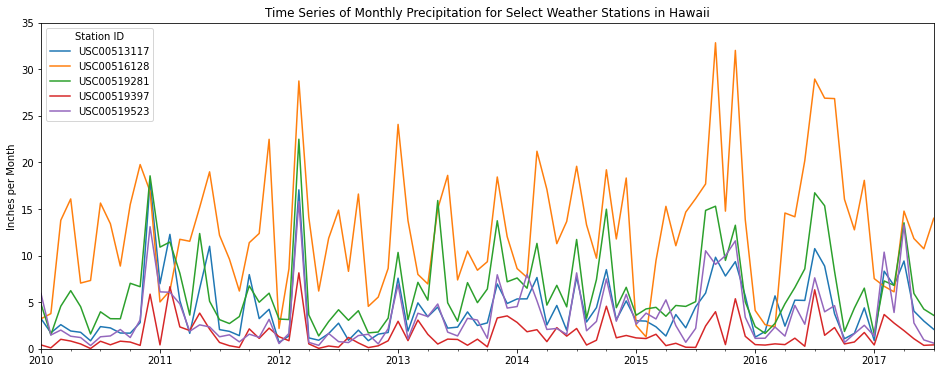

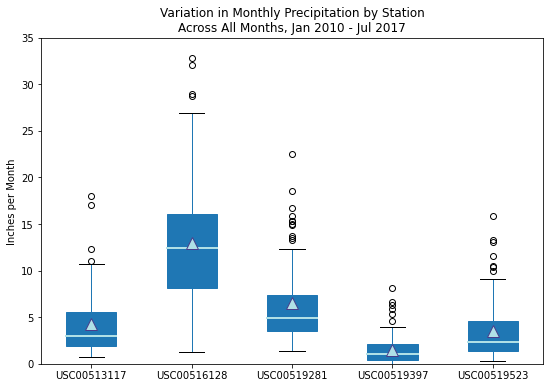

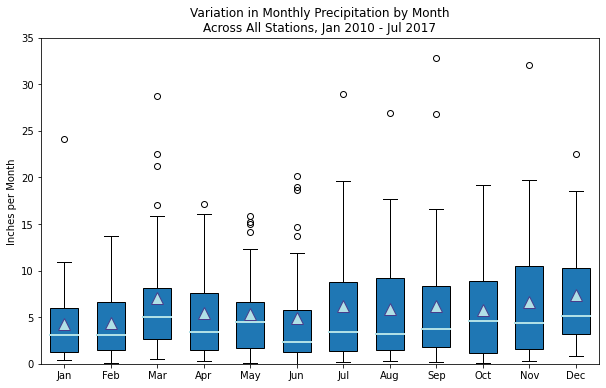

In [93]:
ax = df_prec_sum.plot(figsize=(16,6), ylim=(0,35), xlabel='', ylabel='Inches per Month',
                 title='Time Series of Monthly Precipitation for Select Weather Stations in Hawaii')
ax.legend(title='Station ID')
plt.show();

medianprops = {'linewidth':2, 'color':'PowderBlue'}
meanprops = {'markersize':12, 'markerfacecolor':'PowderBlue', 'markeredgecolor':'DarkSlateBlue'}
df_prec_sum.plot.box(medianprops=medianprops, showmeans=True, meanprops=meanprops, figsize=(9,6), 
                     patch_artist=True, ylabel='Inches per Month', ylim=(0,35), 
                     title='Variation in Monthly Precipitation by Station\nAcross All Months, Jan 2010 - Jul 2017');
plt.show();


df_prec_sum_stack = df_prec_sum.stack()
gb_prec_mo = df_prec_sum_stack.groupby(lambda x: x.strftime("%b"), level='Year_Mo', sort=False)

labels = []
groups = []
for name, grp in gb_prec_mo:
    labels.append(name)
    groups.append(grp.values)

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(groups, patch_artist=True, labels=labels, showmeans=True, medianprops=medianprops, 
           meanprops=meanprops, widths=0.6)
ax.set_ylim(0,35)
ax.set_ylabel('Inches per Month')
ax.set_title('Variation in Monthly Precipitation by Month\nAcross All Stations, Jan 2010 - Jul 2017')
plt.show();


In [78]:
df_temp_count = pd.pivot_table(df_meas, values='Temp', index='Year_Mo', columns='Sta_ID', aggfunc='count')
df_temp_pcnt = df_temp_count.divide(s_daysinmonth, axis=0)

cm = sns.light_palette("darkred", as_cmap=True).reversed()
display(df_temp_pcnt.style.background_gradient(cmap=cm, axis=None))

df_temp_mean = pd.pivot_table(df_meas, values='Temp', index='Year_Mo', columns='Sta_ID', aggfunc='mean')

sta_keep = ['USC00513117','USC00516128','USC00519281','USC00519397','USC00519523']
df_temp_mean = df_temp_mean[sta_keep]
display(df_temp_mean.style.background_gradient(cmap='RdYlGn_r', axis=None))

Sta_ID,USC00511918,USC00513117,USC00514830,USC00516128,USC00517948,USC00518838,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,,,,,
2010-01,0.935484,1.000000,nan,1.000000,nan,0.645161,1.000000,0.903226,1.000000
2010-02,0.928571,0.928571,nan,0.928571,nan,0.714286,1.000000,0.857143,1.000000
2010-03,0.967742,1.000000,0.903226,1.000000,nan,0.612903,1.000000,0.838710,1.000000
2010-04,1.000000,1.000000,0.966667,0.966667,nan,0.733333,1.000000,0.866667,1.000000
2010-05,0.967742,1.000000,0.903226,0.870968,0.612903,0.709677,1.000000,0.935484,0.935484
2010-06,0.966667,1.000000,0.966667,0.733333,0.666667,0.766667,1.000000,1.000000,0.966667
2010-07,0.903226,1.000000,0.870968,1.000000,0.451613,0.483871,1.000000,0.870968,1.000000
2010-08,1.000000,1.000000,1.000000,1.000000,0.677419,0.677419,1.000000,1.000000,1.000000
2010-09,0.933333,0.966667,1.000000,1.000000,0.633333,0.766667,1.000000,0.966667,1.000000


Sta_ID,USC00513117,USC00516128,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,
2010-01,70.225806,69.419355,68.612903,68.285714,69.967742
2010-02,68.076923,68.384615,66.464286,68.000000,68.035714
2010-03,70.064516,69.161290,69.354839,71.384615,71.612903
2010-04,71.066667,70.724138,70.100000,73.576923,72.200000
2010-05,73.387097,72.629630,72.419355,76.344828,75.551724
2010-06,74.800000,72.863636,73.633333,77.766667,76.172414
2010-07,74.290323,70.580645,72.580645,77.407407,75.935484
2010-08,74.451613,71.000000,74.967742,77.612903,76.387097
2010-09,74.931034,71.833333,73.266667,77.103448,76.033333


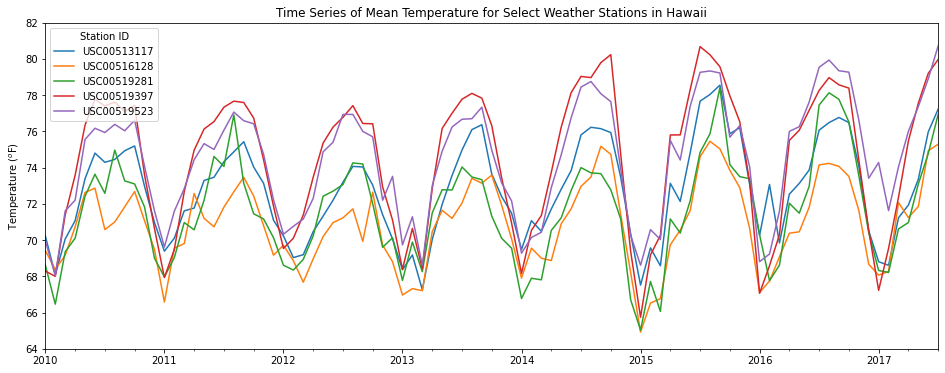

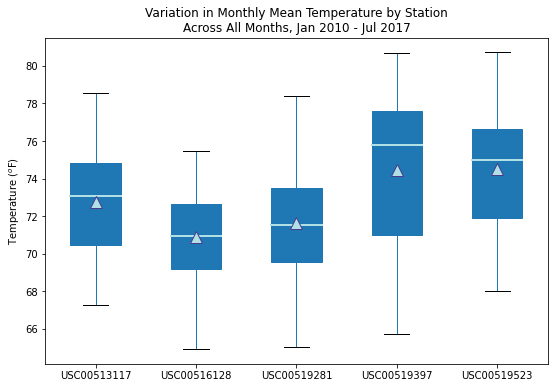

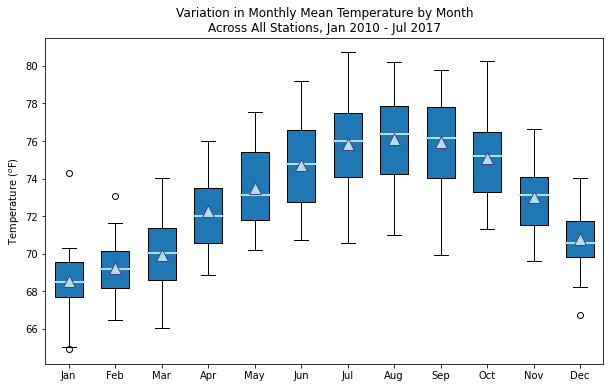

In [94]:
ax = df_temp_mean.plot(figsize=(16,6), xlabel='', ylim=(64,82), ylabel='Temperature ($^o$F)',
                 title='Time Series of Mean Temperature for Select Weather Stations in Hawaii')
ax.legend(title='Station ID')
plt.show();

medianprops = {'linewidth':2, 'color':'PowderBlue'}
meanprops = {'markersize':12, 'markerfacecolor':'PowderBlue', 'markeredgecolor':'DarkSlateBlue'}
df_temp_mean.plot.box(medianprops=medianprops, showmeans=True, meanprops=meanprops, figsize=(9,6), 
                     patch_artist=True, ylabel='Temperature ($^o$F)',  
                     title='Variation in Monthly Mean Temperature by Station\nAcross All Months, Jan 2010 - Jul 2017');
plt.show();


df_temp_mean_stack = df_temp_mean.stack()
gb_temp_mo = df_temp_mean_stack.groupby(lambda x: x.strftime("%b"), level='Year_Mo', sort=False)

labels = []
groups = []
for name, grp in gb_temp_mo:
    labels.append(name)
    groups.append(grp.values)

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(groups, patch_artist=True, labels=labels, showmeans=True, medianprops=medianprops, 
           meanprops=meanprops, widths=0.6)
# ax.set_ylim(0,25)
ax.set_ylabel('Temperature ($^o$F)')
ax.set_title('Variation in Monthly Mean Temperature by Month\nAcross All Stations, Jan 2010 - Jul 2017')
plt.show();


ValueError: 'RBu' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'